In [32]:
from numpy import concatenate
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
import numpy as np
import tensorflow as tf
import keras
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import StandardScaler

In [33]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [34]:
tf.test.is_built_with_gpu_support()

True

In [35]:
#data1 = 'simulated_data_sep_var_ambas_T_rn_50sep_nueva_bien_1.csv'
#data2 = 'simulated_data_sep_var_ambas_T_rn_50sep_nueva_bien_2.csv'
#data1 = 'simulated_data_sep_var_ambas_T_rn_100_sep_nueva_bien_1.csv'
#data2 = 'simulated_data_sep_var_ambas_T_rn_100_sep_nueva_bien_2.csv'
#data3 = 'simulated_data_sep_var_ambas_T_rn_100_sep_nueva_bien_3.csv'
#data1 = 'simulated_data_sep_var_ambas_T_rn_150.csv'
#data2 = 'simulated_data_sep_var_ambas_T_rn_150_2.csv'
#data1 = 'simulated_data_sep_var_100_800k_novdesv.csv'
#data2 = 'simulated_data_sep_var_100_800k_novdesv_2.csv'
#data1 = 'simulated_data_sep_var_150_800k_novdesv.csv'
#data2 = 'simulated_data_sep_var_150_800k_novdesv_2.csv'
data1 = 'simulated_data_sep_var_50_800k_novdesv.csv'
#data2 = 'simulated_data_sep_var_50_800k_novdesv_2.csv'
time = 1

In [36]:
dataset1 = read_csv(f'./Simulations/{data1}', header=0, index_col=0, sep = ';')
#dataset2 = read_csv(f'./Simulations/{data2}, header=0, index_col=0, sep = ';')
#dataset = pd.concat([dataset1,dataset2],ignore_index=True)
dataset = dataset1
values = dataset.values
values

array([[25.0075091 , 69.98262207, 10.00829707, 54.20282996],
       [25.02046209, 69.99597894, 10.00119401, 54.20211761],
       [24.9828642 , 69.98555891, 10.00194379, 54.186973  ],
       ...,
       [25.48100859, 75.00039373, 12.83510324, 55.93047515],
       [25.45860545, 74.99359481, 12.83101851, 55.93377794],
       [25.4981747 , 75.01080619, 12.83503997, 55.93715282]])

In [37]:
n = len(dataset)
n

800000

In [38]:
a = dataset.describe()
a.to_clipboard()

In [39]:
column_indices = {name: i for i, name in enumerate(dataset.columns)}
n = len(dataset)
train_df = dataset[0:time*int(n*0.7)]
val_df = dataset[time*int(n*0.7):time*int(n*0.9)]
test_df = dataset[time*int(n*0.9):]
num_features = dataset.shape[1]
num_features

4

In [40]:
n

800000

In [41]:
train_mean = train_df.mean()
train_std = train_df.std()


In [42]:
train_mean

Outer Temp.            25.041515
Initial Inner Temp.    69.902352
Outer Ws               10.039647
Inner Temp.            55.038887
dtype: float64

In [43]:
train_std

Outer Temp.            2.929728
Initial Inner Temp.    5.753829
Outer Ws               5.711073
Inner Temp.            4.768334
dtype: float64

In [44]:
train_df

,Outer Temp.,Initial Inner Temp.,Outer Ws,Inner Temp.
0.25,25.007509,69.982622,10.008297,54.202830
1.25,25.020462,69.995979,10.001194,54.202118
2.25,24.982864,69.985559,10.001944,54.186973
3.25,24.997971,69.995884,10.005157,54.221797
4.25,25.017789,69.996538,10.009373,54.217650
...,...,...,...,...
559995.25,29.717885,78.265719,5.674056,63.261275
559996.25,29.694693,78.257510,5.685929,63.285908
559997.25,29.719792,78.262762,5.674237,63.277017
559998.25,29.698226,78.255168,5.675991,63.273067


In [45]:
train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std


In [46]:
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

In [47]:
def split_window(self, features):
  inputs = features[:, self.input_slice, :]
  labels = features[:, self.labels_slice, :]
  if self.label_columns is not None:
    labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)


  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])

  return inputs, labels

WindowGenerator.split_window = split_window

In [48]:
def make_dataset(self, data):
  data = np.array(data, dtype=np.float32)
  ds = tf.keras.utils.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=True,
      batch_size=128,)

  ds = ds.map(self.split_window)

  return ds

WindowGenerator.make_dataset = make_dataset

In [49]:
@property
def train(self):
  return self.make_dataset(self.train_df)

@property
def val(self):
  return self.make_dataset(self.val_df)

@property
def test(self):
  return self.make_dataset(self.test_df)

@property
def example(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = next(iter(self.val))
  self._example = result
  return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

In [50]:
def split_window(self, features):
  inputs = features[:, self.input_slice, :]
  labels = features[:, self.labels_slice, :]
  if self.label_columns is not None:
    labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])

  return inputs, labels

WindowGenerator.split_window = split_window

In [51]:
val_performance = {}
performance = {}

In [52]:
MAX_EPOCHS = 15

def compile_and_fit(model, window, patience=2):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

  model.compile(loss=tf.losses.MeanAbsoluteError(),
                optimizer=tf.optimizers.Adam(),
                metrics=[tf.metrics.MeanAbsoluteError()])

  history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping])
  return history

In [53]:
OUT_STEPS = 60
multi_window = WindowGenerator(input_width=90,
                               label_width=OUT_STEPS,
                               shift=OUT_STEPS,
                               label_columns=['Inner Temp.'])

In [54]:
def plot(self, model=None, plot_col='Inner Temp.', max_subplots=3):
  inputs, labels = self.example
  plt.figure(figsize=(12, 80))
  plot_col_index = self.column_indices[plot_col]
  max_n = min(max_subplots, len(inputs))
  for n in range(max_n):
    plt.subplot(max_n, 1, n+1)
    plt.ylabel(f'{plot_col} [normed]')
    plt.plot(self.input_indices, inputs[n, :, plot_col_index],
             label='Inputs', marker='.', zorder=-10)

    if self.label_columns:
      label_col_index = self.label_columns_indices.get(plot_col, None)
    else:
      label_col_index = plot_col_index

    if label_col_index is None:
      continue

    plt.scatter(self.label_indices, labels[n, :, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
    if model is not None:
      predictions = model(inputs)
      plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)

    if n == 0:
      plt.legend()

  plt.xlabel('Time [s]')

WindowGenerator.plot = plot

In [55]:
multi_lstm_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, lstm_units].
    # Adding more `lstm_units` just overfits more quickly.
    tf.keras.layers.LSTM(150, return_sequences=False),
    
    # Shape => [batch, out_steps*features].
    tf.keras.layers.Dense(OUT_STEPS,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features].
    tf.keras.layers.Reshape([OUT_STEPS, 1])
])
history = compile_and_fit(multi_lstm_model, multi_window)
1

multi_val_performance = multi_lstm_model.evaluate(multi_window.val)
multi_performance = multi_lstm_model.evaluate(multi_window.test, verbose=0)
#multi_window.plot(multi_lstm_model)

Epoch 1/15
 441/4374 [==>...........................] - ETA: 29s - loss: 0.1510 - mean_absolute_error: 0.1510

KeyboardInterrupt: 

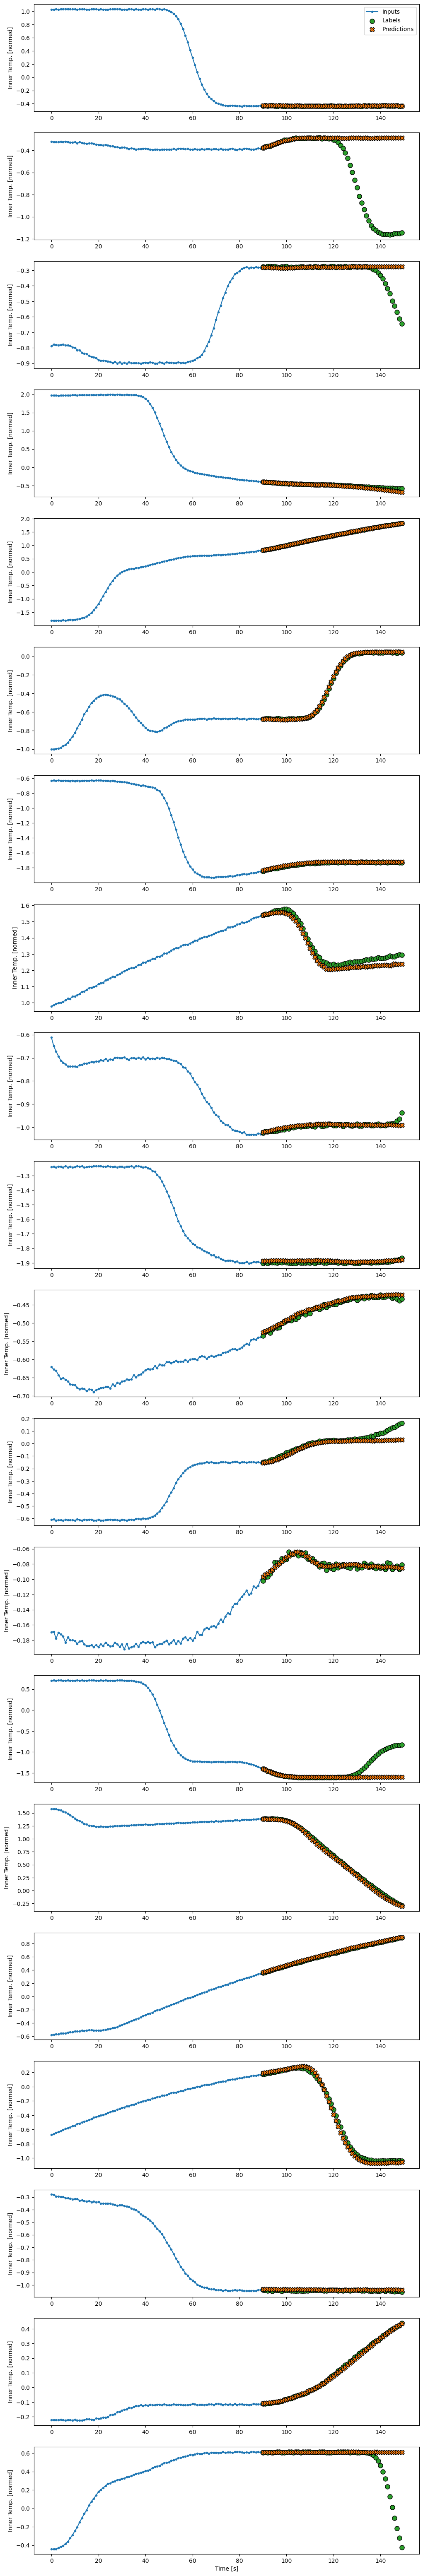

In [ ]:
multi_window.plot(multi_lstm_model, max_subplots= 20)

In [ ]:
#multi_lstm_model.save('double_model_random_60_24/my_model')

In [ ]:
#multi_lstm_model.save('model_90_24_con_sep150_1600k_90_mae/my_model')

In [ ]:
multi_lstm_model.save('m60_n90_s150_i50_l1600k/my_model',save_format = 'h5')